In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
from copy import deepcopy

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
# gpus = jax.devices()
# jax.config.update("jax_default_device",gpus[0])
jax.config.update("jax_platform_name", "cpu")
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import equinox as eqx 

In [5]:
from mc2.utils.final_data_evaluation import (
    FINAL_MATERIALS, TestSet, ResultSet, predict_test_scenarios, validate_result_set, visualize_result_set
)
from mc2.utils.model_evaluation import reconstruct_model_from_exp_id, get_exp_ids
from mc2.model_interfaces.model_interface import ModelInterface, load_model, count_model_parameters

---

## Checkout available models:

In [3]:
FINAL_MATERIALS

['A', 'B', 'C', 'D', 'E']

In [ ]:
for material_name in FINAL_MATERIALS:
    print(material_name)
    print(get_exp_ids(material_name=material_name, model_type=None))
    #print(len(get_exp_ids(material_name=material_name, model_type=None)))
    print()

In [ ]:
get_exp_ids(material_name="E", model_type=None)

## Choose and load models:

In [ ]:
exp_ids = {
    "A": 'A_GRU16_noHtrafo_bfc6f194_seed1',
    "B": 'B_GRU16_noHtrafo_3f9be931_seed3',
    "C": 'C_GRU16_noHtrafo_fcfa61a9_seed2',
    "D": 'D_GRU16_noHtrafo_2a9981ae_seed3',
    "E": 'E_GRU16_noHtrafo_8f6b000e_seed3',
}

models = {material_name: reconstruct_model_from_exp_id(exp_id) for material_name, exp_id in exp_ids.items()}
# models

In [ ]:
from mc2.runners.model_setup_jax import get_normalizer
_, (_, _, test_setA) = get_normalizer("A", models["A"][0].featurize, subsampling_freq=1, do_normalization=True)
_, (_, _, test_setB) = get_normalizer("B", models["B"][0].featurize, subsampling_freq=1, do_normalization=True)
_, (_, _, test_setC) = get_normalizer("C", models["C"][0].featurize, subsampling_freq=1, do_normalization=True)
_, (_, _, test_setD) = get_normalizer("D", models["D"][0].featurize, subsampling_freq=1, do_normalization=True)
_, (_, _, test_setE) = get_normalizer("E", models["E"][0].featurize, subsampling_freq=1, do_normalization=True)
tests_sets = {
    "A": test_setA,
    "B": test_setB,
    "C": test_setC,
    "D": test_setD,
    "E": test_setE,
}

In [ ]:
from IPython.display import display, HTML
from mc2.utils.model_evaluation import evaluate_cross_validation
from mc2.utils.final_data_evaluation import FINAL_SCENARIOS_PER_MATERIAL
from mc2.utils.pretest_evaluation import create_multilevel_df

In [ ]:
loader_key = jax.random.PRNGKey(32)

metrics = evaluate_cross_validation(
    wrapped_model=models["A"][0],
    test_set=test_setA,
    scenarios=FINAL_SCENARIOS_PER_MATERIAL[test_setA.material_name],
    sequence_length=1000,
    batch_size_per_frequency=1000,
    loader_key=loader_key,
);

In [ ]:
get_exp_ids(material_name="B", model_type=None)

## Comparison

In [ ]:
model_types=["GRU4","GRU5","GRU6","GRU7","GRU8","GRU9","GRU10","GRU11","GRU12","GRU13","GRU14","GRU15","GRU16"]
exp_ids_mats={}
for mat in ["A","B","C","D","E"]:
    chosen_exp_ids_mat=[]
    exp_ids_mat=get_exp_ids(material_name=mat, model_type=None)
    for mod_type in model_types:
        for epx_id in exp_ids_mat:
            split_name=epx_id.split("_")
            if "noHtrafo" in split_name:
                if mod_type==split_name[1]:
                    chosen_exp_ids_mat.append("_".join(split_name[:-1]))
                    break
    exp_ids_mats[mat]=chosen_exp_ids_mat

In [ ]:
import pickle
# exp_ids_A= ["A_GRU2_c5b34311","A_GRU4_2f253f50","A_GRU8_e3dafb3f","A_GRU16_4c256cf5","A_GRU32_9599d864"]
# exp_ids_B= ["B_GRU2_f1b2cd83","B_GRU4_f0ba9496","B_GRU8_d683de50","B_GRU16_716a1872","B_GRU32_22bd5f1d"]
# exp_ids_C= ["C_GRU2_996b2632","C_GRU4_a182a3df","C_GRU8_7b9eacd3","C_GRU16_ea3ac834","C_GRU32_f53a32d3"] #trained on past_size=16 -> ["C_GRU2_6b8b5ab0","C_GRU4_d08dd853","C_GRU8_680ee824","C_GRU16_4531b69d","C_GRU32_7ffd53c3"]
# exp_ids_D= ["D_GRU2_67ff4bc8","D_GRU4_7a2e887e","D_GRU8_88824f39","D_GRU16_6dae2501","D_GRU32_a3bfba7b"]
# exp_ids_E= ["E_GRU2_7146d23b","E_GRU4_d21d91eb","E_GRU8_da006b10","E_GRU16_9b901cd4","E_GRU32_0374ac59"]

exp_ids_A= exp_ids_mats["A"]
exp_ids_B= exp_ids_mats["B"]
exp_ids_C= exp_ids_mats["C"]
exp_ids_D= exp_ids_mats["D"]
exp_ids_E= exp_ids_mats["E"]
# generate normalizer and data_tuple 
all_result_all_mats = {}
loader_key = jax.random.PRNGKey(32)

for exp_ids,mat_name in zip([exp_ids_A,exp_ids_B,exp_ids_C,exp_ids_D,exp_ids_E],["A","B","C","D","E"]):
    wrapped_model, data_tuple = reconstruct_model_from_exp_id(exp_ids[0]+"_seed1")
    normalizer= wrapped_model.normalizer
    all_results = []
    table_result={}
    for exp_id in exp_ids:
        for seed in (range(1, 4)): #4
            full_exp_id = exp_id + f"_seed{seed}"
            model_type = full_exp_id.split("_")[1]
            
            wrapped_model, _ = reconstruct_model_from_exp_id(full_exp_id,normalizer=normalizer,data_tuple=data_tuple)
            test_set=tests_sets[mat_name]
            metrics = evaluate_cross_validation(
                wrapped_model=wrapped_model,
                test_set=test_set,
                scenarios=FINAL_SCENARIOS_PER_MATERIAL[mat_name],
                sequence_length=1000,
                batch_size_per_frequency=1000,
                loader_key=loader_key,
            )
            model_params=count_model_parameters(wrapped_model)
    #   
            for scenario, values in metrics.items():
                # SRE
                all_results.append({
                    'Model_Type': model_type, 'Seed': seed, 'Params': model_params, 'Scenario': scenario, 
                    'Metric_Name': 'SRE', 'Value': values['sre_avg'], 'Type': 'Avg'
                })
                all_results.append({
                    'Model_Type': model_type, 'Seed': seed, 'Params': model_params, 'Scenario': scenario, 
                    'Metric_Name': 'SRE', 'Value': values['sre_95th'], 'Type': '95th'
                })
                # NERE
                all_results.append({
                    'Model_Type': model_type, 'Seed': seed, 'Params': model_params, 'Scenario': scenario, 
                    'Metric_Name': 'NERE', 'Value': values['nere_avg'], 'Type': 'Avg'
                })
                all_results.append({
                    'Model_Type': model_type, 'Seed': seed, 'Params': model_params, 'Scenario': scenario, 
                    'Metric_Name': 'NERE', 'Value': values['nere_95th'], 'Type': '95th'
                })

                if seed == 1:
                    table_result[model_type]=metrics


    df = pd.DataFrame(all_results)
    df['Params_Label'] = df['Params'].astype(str)
    all_result_all_mats[mat_name]=df


file_path_pickle = 'all_results_mats_higher_res_nohtrafo.pkl'

with open(file_path_pickle, 'wb') as f:
    pickle.dump(all_result_all_mats, f)

In [6]:
import pickle
import seaborn as sns
file_path_pickle = 'all_results_mats_higher_res_nohtrafo.pkl'
with open(file_path_pickle, 'rb') as f:
    loaded_all_result_all_mats = pickle.load(f)
all_result_all_mats=loaded_all_result_all_mats

In [21]:
all_result_all_mats["B"][all_result_all_mats["E"]["Model_Type"]=="GRU10"]

,Model_Type,Seed,Params,Scenario,Metric_Name,Value,Type,Params_Label
216,GRU10,1,523,10%known_90%unknown,SRE,0.0546,Avg,523
217,GRU10,1,523,10%known_90%unknown,SRE,0.1220,95th,523
218,GRU10,1,523,10%known_90%unknown,NERE,0.1466,Avg,523
219,GRU10,1,523,10%known_90%unknown,NERE,0.5259,95th,523
220,GRU10,1,523,50%known_50%unknown,SRE,0.0524,Avg,523
221,GRU10,1,523,50%known_50%unknown,SRE,0.1234,95th,523
222,GRU10,1,523,50%known_50%unknown,NERE,0.0973,Avg,523
223,GRU10,1,523,50%known_50%unknown,NERE,0.3627,95th,523
224,GRU10,1,523,90%known_10%unknown,SRE,0.0451,Avg,523
225,GRU10,1,523,90%known_10%unknown,SRE,0.1355,95th,523


In [20]:
all_result_all_mats["B"][all_result_all_mats["E"]["Model_Type"]=="GRU8"]

,Model_Type,Seed,Params,Scenario,Metric_Name,Value,Type,Params_Label
144,GRU8,1,371,10%known_90%unknown,SRE,0.0586,Avg,371
145,GRU8,1,371,10%known_90%unknown,SRE,0.1306,95th,371
146,GRU8,1,371,10%known_90%unknown,NERE,0.1739,Avg,371
147,GRU8,1,371,10%known_90%unknown,NERE,0.6392,95th,371
148,GRU8,1,371,50%known_50%unknown,SRE,0.0567,Avg,371
149,GRU8,1,371,50%known_50%unknown,SRE,0.1349,95th,371
150,GRU8,1,371,50%known_50%unknown,NERE,0.1093,Avg,371
151,GRU8,1,371,50%known_50%unknown,NERE,0.4045,95th,371
152,GRU8,1,371,90%known_10%unknown,SRE,0.0502,Avg,371
153,GRU8,1,371,90%known_10%unknown,SRE,0.1525,95th,371


In [13]:
all_result_all_mats

{'A':     Model_Type  Seed  Params             Scenario Metric_Name    Value  Type  \
 0         GRU4     1     139  10%known_90%unknown         SRE   0.2151   Avg   
 1         GRU4     1     139  10%known_90%unknown         SRE   0.4396  95th   
 2         GRU4     1     139  10%known_90%unknown        NERE   2.4759   Avg   
 3         GRU4     1     139  10%known_90%unknown        NERE  15.5723  95th   
 4         GRU4     1     139  50%known_50%unknown         SRE   0.2006   Avg   
 ..         ...   ...     ...                  ...         ...      ...   ...   
 463      GRU16     3    1123  50%known_50%unknown        NERE   6.0110  95th   
 464      GRU16     3    1123  90%known_10%unknown         SRE   0.1201   Avg   
 465      GRU16     3    1123  90%known_10%unknown         SRE   0.3139  95th   
 466      GRU16     3    1123  90%known_10%unknown        NERE   0.1581   Avg   
 467      GRU16     3    1123  90%known_10%unknown        NERE   1.0747  95th   
 
     Params_Label  
 

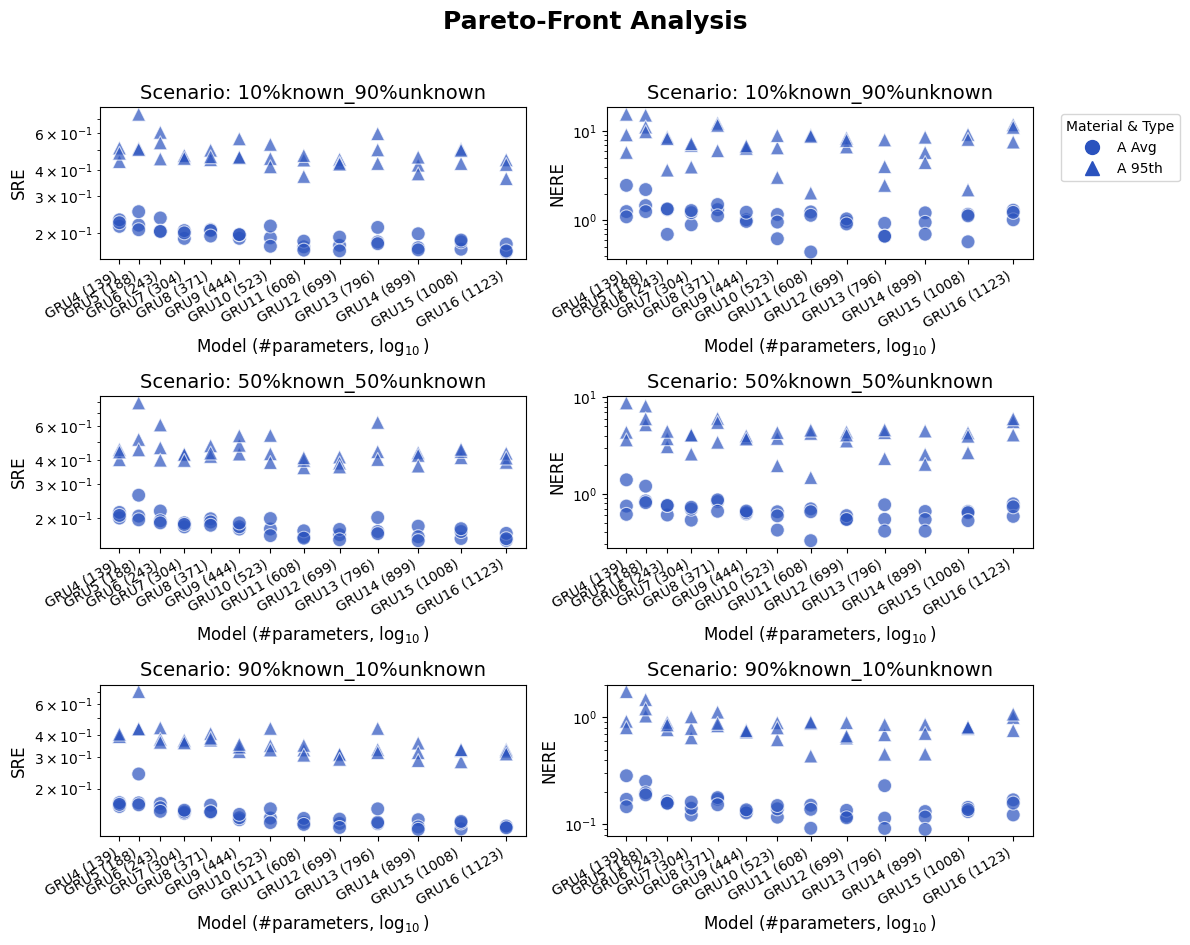

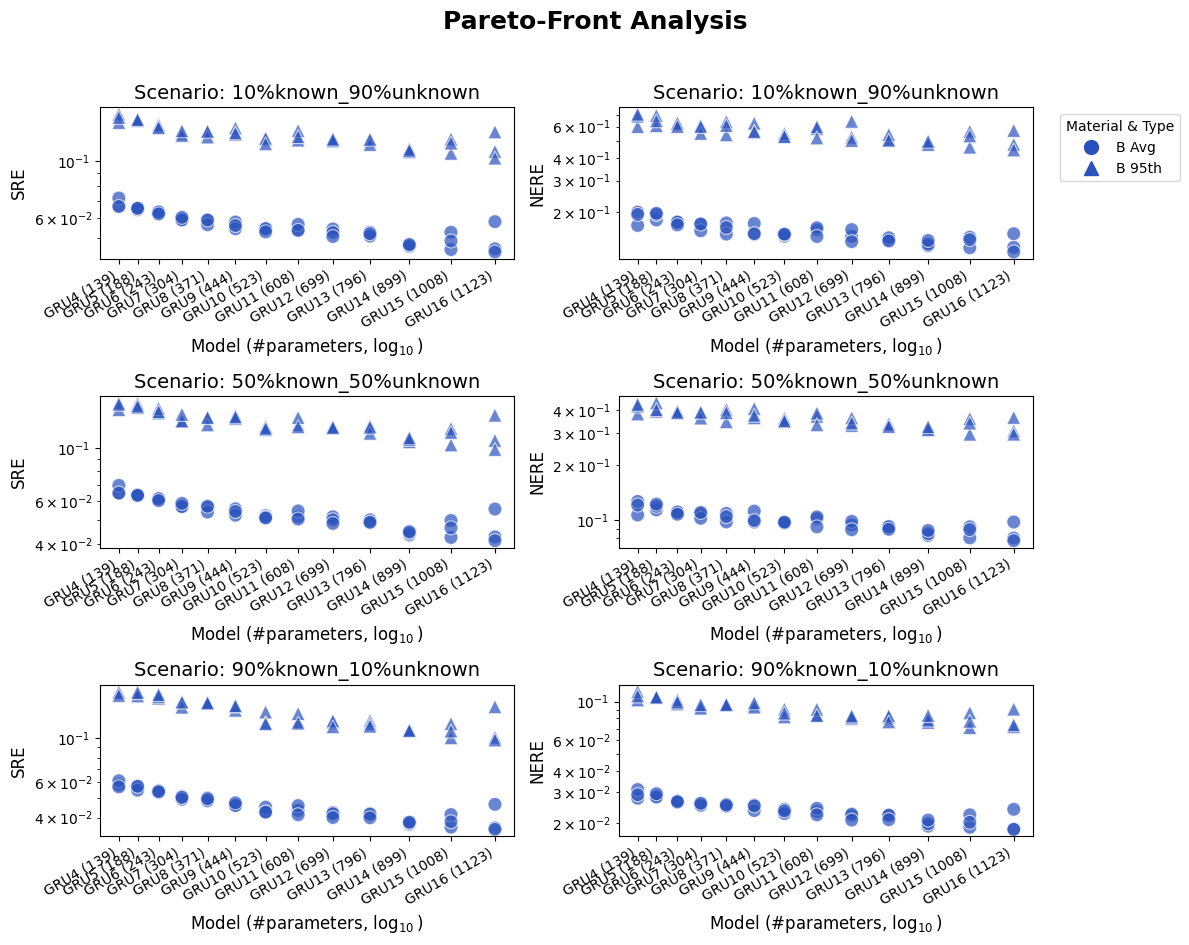

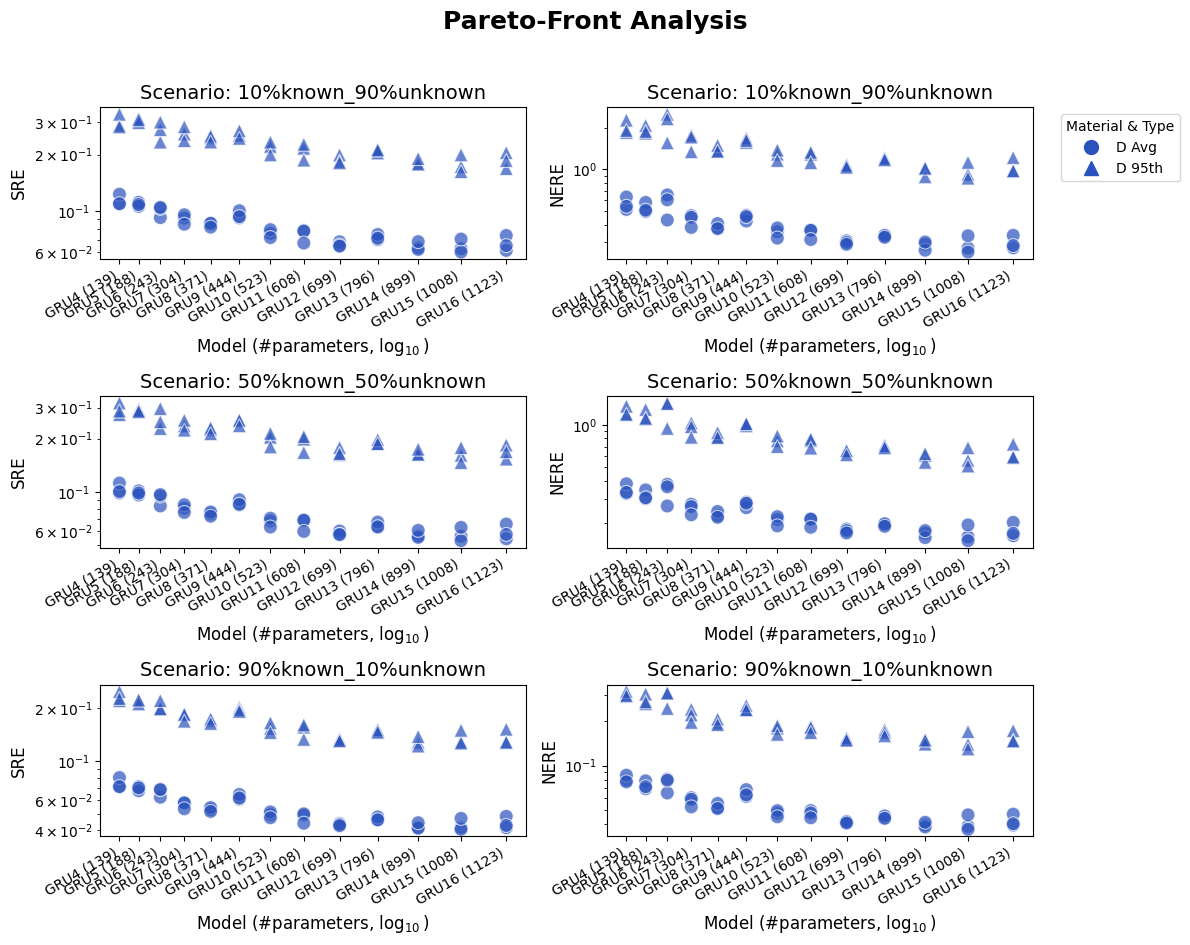

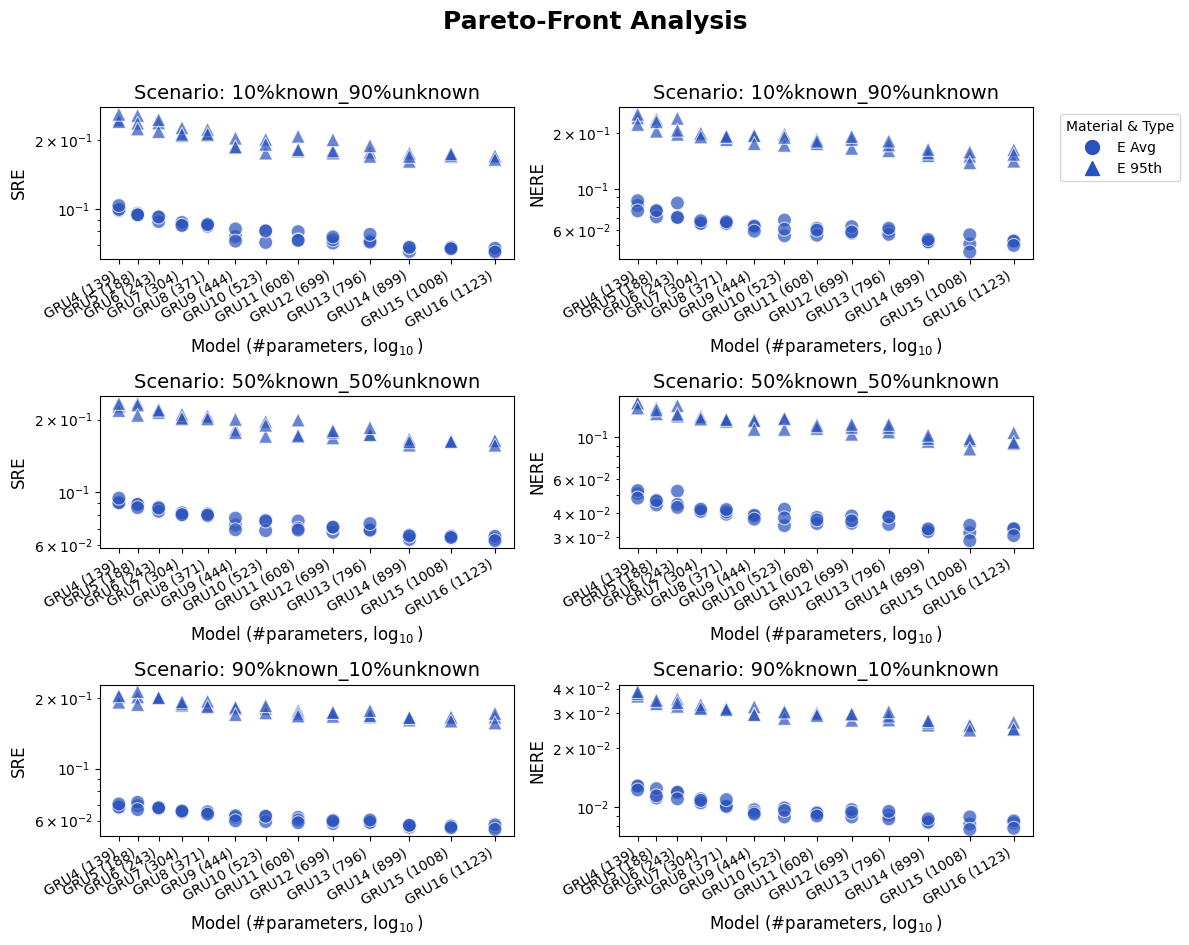

In [7]:
material_names=["A","B","C","D","E"]
for matera in ["A","B","D","E"]:
    combined_df = []
    materials = []
    ignore_materials=material_names.copy() #
    ignore_materials.remove(matera)
    x_log = False
    y_log = True
    for mat_name, df in all_result_all_mats.items():
        if mat_name in ignore_materials:
            continue

        df_copy = df.copy()
        df_copy['Material'] = mat_name
        materials.append(mat_name)


        df_copy['Model_Param_ID'] = df_copy['Model_Type'] + ' (' + df_copy['Params_Label'] + ')'
        df_copy['Params'] = df_copy['Model_Param_ID'].str.split('(').str[1].str.strip(')').astype(int)
        df_copy['Log_Params'] = np.log10(df_copy['Params'])
        if x_log:
            x_plot = 'Log_Params'
        else:
            x_plot = 'Params'
        # New combined hue column: 'Material_Type'
        df_copy['Hue_Group'] = df_copy['Material'] + '_' + df_copy['Type']
        combined_df.append(df_copy)
    if not combined_df:
        print(f"No data available after excluding Materials: {ignore_materials}.")
        # return
    df_all_mats = pd.concat(combined_df, ignore_index=True)



    materials = sorted(list(set(materials))) 
    palette_map = {}
    marker_map = {}

    color_pairs = [
        ( '#2A52BE','#2A52BE'),  # Light Blue / Dark Blue
        ( '#ff7f0e','#ff7f0e'),  # Light Orange / Dark Orange
        ( '#2ca02c','#2ca02c'),
        ('#CC0000', '#CC0000'),  # Light Green / Dark Green
        ( '#957DAD','#E0BBE4'),  # Light Purple / Dark Purple
        ( '#FAA0A0','#FEE1E8',),  # Light Pink / Dark Pink
        ('#F7E9B6', '#B8860B'),  # Light Yellow / Dark Yellow (DarkGoldenrod)

    ]

    markers = ['o', 's', '^', 'D', 'v', 'P', '*']

    for i, mat in enumerate(materials):


        color_pair = color_pairs[i % len(color_pairs)]
        marker= markers[i % len(markers)]
        palette_map[f'{mat}_Avg'] = color_pair[0]  
        palette_map[f'{mat}_95th'] = color_pair[1] 
        #marker_map[mat] = marker

    marker_map = {
        'Avg': 'o',
        '95th': '^'
    }


    metrics = ['SRE', 'NERE']
    scenarios = ["10%known_90%unknown", "50%known_50%unknown", "90%known_10%unknown"]
    fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(metrics), figsize=(12, 10))
    axes = np.atleast_2d(axes) 


    full_tick_map = (df_all_mats[[x_plot, 'Model_Param_ID']]
                    .drop_duplicates()
                    .sort_values(x_plot))
    for i, scenario in enumerate(scenarios):

        df_scenario = df_all_mats[df_all_mats['Scenario'] == scenario]
        for j, metric in enumerate(metrics):

            ax = axes[i, j]
            df_plot = df_scenario[df_scenario['Metric_Name'] == metric]
            sns.scatterplot(
                x=x_plot,
                y='Value',
                hue='Hue_Group', # Use the combined column for hue
                data=df_plot,
                palette=palette_map, # Use the custom palette
                ax=ax,
                s=100,
                style='Type', 
                markers=marker_map,
                alpha=0.7,
            )

            
            ax.set_title(f'Scenario: {scenario}', fontsize=14)
            ax.set_ylabel(f'{metric}', fontsize=12)
            ax.set_xlabel('Model (#parameters, $\\log_{10}$)', fontsize=12)
            ax.set_xticks(full_tick_map[x_plot].values)
            if y_log:
                ax.set_yscale("log")
            ax.set_xticklabels(full_tick_map['Model_Param_ID'].values, rotation=30, ha='right')
        
            if j == 1 and i == 0:

                def get_handle_color(handle):
                    if hasattr(handle, "get_facecolor"):
                        fc = handle.get_facecolor()
                        if len(fc) > 0:
                            return fc[0]
                    if hasattr(handle, "get_color"):
                        return handle.get_color()
                    return "black"
                
                handles, labels = ax.get_legend_handles_labels()

                valid_entries = []
                for idx, lab in enumerate(labels):
                    # nur Labels wie A_Avg, B_95th
                    if "_" not in lab:
                        continue
                    parts = lab.split("_")
                    if len(parts) != 2:
                        continue
                    mat, typ = parts
                    if typ not in ["Avg", "95th"]:
                        continue
                    valid_entries.append((idx, mat, typ))

                new_handles = []
                new_labels  = []

                for idx, mat, typ in valid_entries:
                    handle = handles[idx]
                    color  = get_handle_color(handle)
                    marker = marker_map[typ]

                    new_handle = plt.Line2D(
                        [], [],
                        color=color,
                        marker=marker,
                        linestyle='',
                        markersize=10
                    )

                    new_handles.append(new_handle)
                    new_labels.append(f"{mat} {typ}")

                ax.legend(
                    new_handles,
                    new_labels,
                    title="Material & Type",
                    loc='upper left',
                    bbox_to_anchor=(1.05, 1.0)
                )
            else:
                ax.get_legend().remove()

    fig.suptitle(f'Pareto-Front Analysis', #- Combined Materials (Excluding {", ".join(ignore_materials)})

                fontsize=18, fontweight='bold', y=0.97)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


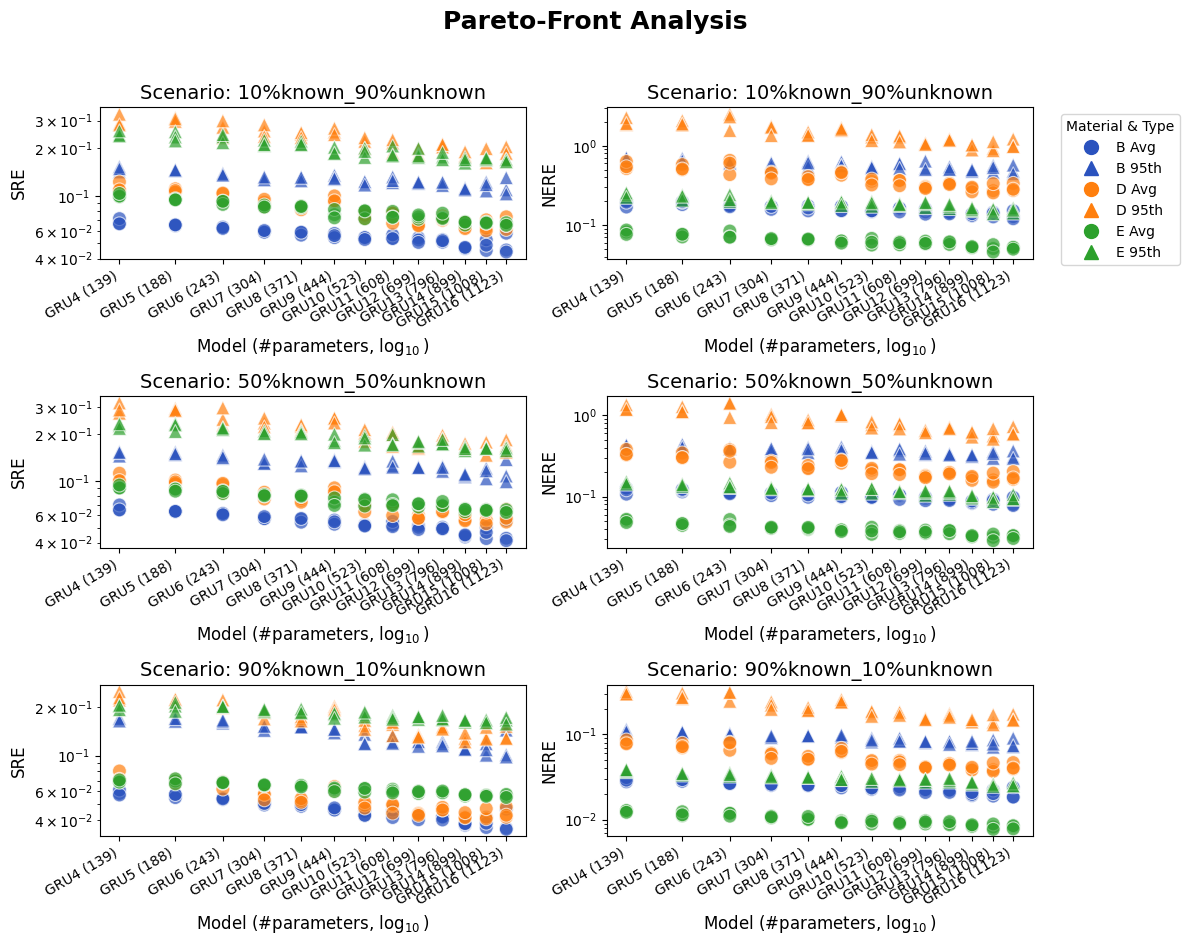

In [8]:

combined_df = []
materials = []
ignore_materials=["A","C"] #
x_log = True
y_log = True
for mat_name, df in all_result_all_mats.items():
    if mat_name in ignore_materials:
        continue

    df_copy = df.copy()
    df_copy['Material'] = mat_name
    materials.append(mat_name)


    df_copy['Model_Param_ID'] = df_copy['Model_Type'] + ' (' + df_copy['Params_Label'] + ')'
    df_copy['Params'] = df_copy['Model_Param_ID'].str.split('(').str[1].str.strip(')').astype(int)
    df_copy['Log_Params'] = np.log10(df_copy['Params'])
    if x_log:
        x_plot = 'Log_Params'
    else:
        x_plot = 'Params'
    # New combined hue column: 'Material_Type'
    df_copy['Hue_Group'] = df_copy['Material'] + '_' + df_copy['Type']
    combined_df.append(df_copy)
if not combined_df:
    print(f"No data available after excluding Materials: {ignore_materials}.")
    # return
df_all_mats = pd.concat(combined_df, ignore_index=True)



materials = sorted(list(set(materials))) 
palette_map = {}
marker_map = {}

color_pairs = [
    ( '#2A52BE','#2A52BE'),  # Light Blue / Dark Blue
    ( '#ff7f0e','#ff7f0e'),  # Light Orange / Dark Orange
    ( '#2ca02c','#2ca02c'),
    ('#CC0000', '#CC0000'),  # Light Green / Dark Green
    ( '#957DAD','#E0BBE4'),  # Light Purple / Dark Purple
    ( '#FAA0A0','#FEE1E8',),  # Light Pink / Dark Pink
    ('#F7E9B6', '#B8860B'),  # Light Yellow / Dark Yellow (DarkGoldenrod)

]

markers = ['o', 's', '^', 'D', 'v', 'P', '*']

for i, mat in enumerate(materials):


    color_pair = color_pairs[i % len(color_pairs)]
    marker= markers[i % len(markers)]
    palette_map[f'{mat}_Avg'] = color_pair[0]  
    palette_map[f'{mat}_95th'] = color_pair[1] 
    #marker_map[mat] = marker

marker_map = {
    'Avg': 'o',
    '95th': '^'
}


metrics = ['SRE', 'NERE']
scenarios = ["10%known_90%unknown", "50%known_50%unknown", "90%known_10%unknown"]
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(metrics), figsize=(12, 10))
axes = np.atleast_2d(axes) 


full_tick_map = (df_all_mats[[x_plot, 'Model_Param_ID']]
                 .drop_duplicates()
                 .sort_values(x_plot))
for i, scenario in enumerate(scenarios):

    df_scenario = df_all_mats[df_all_mats['Scenario'] == scenario]
    for j, metric in enumerate(metrics):

        ax = axes[i, j]
        df_plot = df_scenario[df_scenario['Metric_Name'] == metric]
        sns.scatterplot(
            x=x_plot,
            y='Value',
            hue='Hue_Group', # Use the combined column for hue
            data=df_plot,
            palette=palette_map, # Use the custom palette
            ax=ax,
            s=100,
            style='Type', 
            markers=marker_map,
            alpha=0.7,
        )

        
        ax.set_title(f'Scenario: {scenario}', fontsize=14)
        ax.set_ylabel(f'{metric}', fontsize=12)
        ax.set_xlabel('Model (#parameters, $\\log_{10}$)', fontsize=12)
        ax.set_xticks(full_tick_map[x_plot].values)
        if y_log:
            ax.set_yscale("log")
        ax.set_xticklabels(full_tick_map['Model_Param_ID'].values, rotation=30, ha='right')
    
        if j == 1 and i == 0:

            def get_handle_color(handle):
                if hasattr(handle, "get_facecolor"):
                    fc = handle.get_facecolor()
                    if len(fc) > 0:
                        return fc[0]
                if hasattr(handle, "get_color"):
                    return handle.get_color()
                return "black"
            
            handles, labels = ax.get_legend_handles_labels()

            valid_entries = []
            for idx, lab in enumerate(labels):
                # nur Labels wie A_Avg, B_95th
                if "_" not in lab:
                    continue
                parts = lab.split("_")
                if len(parts) != 2:
                    continue
                mat, typ = parts
                if typ not in ["Avg", "95th"]:
                    continue
                valid_entries.append((idx, mat, typ))

            new_handles = []
            new_labels  = []

            for idx, mat, typ in valid_entries:
                handle = handles[idx]
                color  = get_handle_color(handle)
                marker = marker_map[typ]

                new_handle = plt.Line2D(
                    [], [],
                    color=color,
                    marker=marker,
                    linestyle='',
                    markersize=10
                )

                new_handles.append(new_handle)
                new_labels.append(f"{mat} {typ}")

            ax.legend(
                new_handles,
                new_labels,
                title="Material & Type",
                loc='upper left',
                bbox_to_anchor=(1.05, 1.0)
            )
        else:
            ax.get_legend().remove()

fig.suptitle(f'Pareto-Front Analysis', #- Combined Materials (Excluding {", ".join(ignore_materials)})

             fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# combined_df = []
# materials = []
# ignore_materials=["A","C"] #
# x_log = True
# y_log = False
# all_mats=[]
# for mat_name, df in all_result_all_mats.items():
#     if mat_name in ignore_materials:
#         all_mats.append(mat_name)
#         continue
        

#     df_copy = df.copy()
#     df_copy['Material'] = mat_name
#     materials.append(mat_name)


#     df_copy['Model_Param_ID'] = df_copy['Model_Type'] + ' (' + df_copy['Params_Label'] + ')'
#     df_copy['Params'] = df_copy['Model_Param_ID'].str.split('(').str[1].str.strip(')').astype(int)
#     df_copy['Log_Params'] = np.log10(df_copy['Params'])
#     if x_log:
#         x_plot = 'Log_Params'
#     else:
#         x_plot = 'Params'
#     # New combined hue column: 'Material_Type'
#     df_copy['Hue_Group'] = df_copy['Material'] + '_' + df_copy['Type']
#     combined_df.append(df_copy)
    
# if not combined_df:
#     print("No data available after excluding Material 'C'.")
#     # return
# df_all_mats = pd.concat(combined_df, ignore_index=True)



# materials = sorted(list(set(materials))) 
# all_mats = sorted(list(set(all_mats))) 
# palette_map = {}
# marker_map = {}

# color_pairs = [
#     ( '#2A52BE','#2A52BE'),  # Light Blue / Dark Blue
#     ( '#ff7f0e','#ff7f0e'), # Light Orange / Dark Orange
#     ( '#2ca02c','#2ca02c'),
#     ('#CC0000', '#CC0000'), 
#      ( '#957DAD','#E0BBE4'),  # Light Green / Dark Green
#       # Light Purple / Dark Purple
#     ( '#FAA0A0','#FEE1E8',),  # Light Pink / Dark Pink
#     ('#F7E9B6', '#B8860B'),  # Light Yellow / Dark Yellow (DarkGoldenrod)
# ]

# markers = ['o', 's', '^', 'D', 'v', 'P', '*']

# for i, mat in enumerate(materials):
#     if mat in materials:
#         color_pair = color_pairs[i % len(color_pairs)]
#         marker= markers[i % len(markers)]
#         palette_map[f'{mat}_Avg'] = color_pair[0]  
#         palette_map[f'{mat}_95th'] = color_pair[1] 
#     #marker_map[mat] = marker

# marker_map = {
#     'Avg': 'o',
#     '95th': '^'
# }

# N_materials = len(materials) 

# unique_x = df_all_mats[x_plot].drop_duplicates().sort_values().reset_index(drop=True)
# if len(unique_x) > 1:
#     delta_x_min = unique_x.diff().min()
#     delta_x_min = delta_x_min if not pd.isna(delta_x_min) else 0.5 
# else:
#     delta_x_min = 0.5 
    
# total_spread_width = 0.5 * delta_x_min

# if N_materials > 1:
#     offset_per_material = total_spread_width / (N_materials - 1)
# else:
#     offset_per_material = 0

# material_to_offset_map = {}
# for i, mat in enumerate(materials):
#     material_to_offset_map[mat] = (i - (N_materials - 1) / 2) * offset_per_material
    

# df_all_mats['x_offset'] = df_all_mats['Material'].map(material_to_offset_map)
# df_all_mats['x_plot_offset'] = df_all_mats[x_plot] + df_all_mats['x_offset']


# x_plot_offset = 'x_plot_offset' 



# metrics = ['SRE', 'NERE']
# scenarios = ["10%known_90%unknown", "50%known_50%unknown", "90%known_10%unknown"]
# fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(metrics), figsize=(14, 10))
# axes = np.atleast_2d(axes) 


# full_tick_map = (df_all_mats[[x_plot, 'Model_Param_ID']]
#                  .drop_duplicates()
#                  .sort_values(x_plot))
                 
# for i, scenario in enumerate(scenarios):

#     df_scenario = df_all_mats[df_all_mats['Scenario'] == scenario]
#     for j, metric in enumerate(metrics):

#         ax = axes[i, j]
#         df_plot = df_scenario[df_scenario['Metric_Name'] == metric]
        
#         sns.scatterplot(
#             x=x_plot_offset, 
#             y='Value',
#             hue='Hue_Group', #
#             data=df_plot,
#             palette=palette_map, 
#             ax=ax,
#             s=100,
#             style='Type', 
#             markers=marker_map,
#             alpha=0.7,
#         )

        
#         ax.set_title(f'Scenario: {scenario}', fontsize=14)
#         ax.set_ylabel(f'{metric}', fontsize=12)
#         ax.set_xlabel('Model (#parameters, $\\log_{10}$)', fontsize=12)
        
#         if y_log:
#             ax.set_yscale('log')
#         ax.set_xticks(full_tick_map[x_plot].values) 
#         ax.set_xticklabels(full_tick_map['Model_Param_ID'].values, rotation=30, ha='right')
    
#         if j == 1 and i == 0:
#             def get_handle_color(handle):
#                 if hasattr(handle, "get_facecolor"):
#                     fc = handle.get_facecolor()
#                     if len(fc) > 0:
#                         return fc[0]
#                 if hasattr(handle, "get_color"):
#                     return handle.get_color()
#                 return "black"
            
#             handles, labels = ax.get_legend_handles_labels()

#             valid_entries = []
#             for idx, lab in enumerate(labels):
#                 if "_" not in lab:
#                     continue
#                 parts = lab.split("_")
#                 if len(parts) != 2:
#                     continue
#                 mat, typ = parts
#                 if typ not in ["Avg", "95th"]:
#                     continue
#                 valid_entries.append((idx, mat, typ))

#             new_handles = []
#             new_labels  = []

#             for idx, mat, typ in valid_entries:
#                 handle = handles[idx]
#                 color  = get_handle_color(handle)
#                 marker = marker_map[typ]

#                 new_handle = plt.Line2D(
#                     [], [],
#                     color=color,
#                     marker=marker,
#                     linestyle='',
#                     markersize=10
#                 )

#                 new_handles.append(new_handle)
#                 new_labels.append(f"{mat} {typ}")

#             ax.legend(
#                 new_handles,
#                 new_labels,
#                 title="Material & Type",
#                 loc='upper left',
#                 bbox_to_anchor=(1.05, 1.0)
#             )
#         else:
#             ax.get_legend().remove()

# fig.suptitle(f'Pareto-Front Analysis', # - Combined Materials (Excluding {", ".join(ignore_materials)})
#              fontsize=18, fontweight='bold', y=0.97)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('pareto_front_analysis_offset.png') # Statt plt.show()